In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
from week6_TRANSFORMER_model import TransformerModel
from week5_LSTM_model import load_data

# Training function
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=100):
    losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, '
                  f'Validation Loss: {val_loss/len(val_loader):.4f}')
        losses.append((train_loss/len(train_loader),val_loss/len(val_loader)))
    return losses

def test_and_visualize(model, losses,test_loader,scaler):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            predictions.append(output.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    # Rescale predictions and actuals back to original scale
    predictions_rescaled = scaler.inverse_transform(predictions)
    actuals_rescaled = scaler.inverse_transform(actuals)

    # Plot results
    plt.figure(figsize=(10,6))
    plt.plot(actuals_rescaled, label='Actual Sales')
    plt.plot(predictions_rescaled, label='Predicted Sales')
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.title('LSTM Sales Forecasting')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(losses)
    # plt.plot(predictions_rescaled, label='Predicted Sales')
    plt.xlabel('Epoch')
    plt.ylabel('MSELoss')
    plt.title('Training process')
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()



In [17]:
params = {'seq_length': 24, 'num_layers': 1, 'nhead': 8, 'lr': 0.01, 'hidden_size': 16, 'batch_size': 64} # From grid search
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_data, val_data, test_data, scaler = load_data('datasets_56102_107707_monthly-beer-production-in-austr.csv',params['seq_length'],device)


# Create data loaders
batch_size = params['batch_size']
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)



# Initialize the model, loss function, and optimizer
model = TransformerModel(hidden_dim=params['hidden_size'],num_layers=params['num_layers'], seq_length=params['seq_length'],input_dim=1,output_dim=1,nhead=params['nhead']).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])



# Train the model
losses = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=100)

Epoch 10, Train Loss: 0.0458, Validation Loss: 0.0340
Epoch 20, Train Loss: 0.0127, Validation Loss: 0.0220
Epoch 30, Train Loss: 0.0102, Validation Loss: 0.0186
Epoch 40, Train Loss: 0.0075, Validation Loss: 0.0144
Epoch 50, Train Loss: 0.0058, Validation Loss: 0.0126
Epoch 60, Train Loss: 0.0050, Validation Loss: 0.0104
Epoch 70, Train Loss: 0.0045, Validation Loss: 0.0104
Epoch 80, Train Loss: 0.0041, Validation Loss: 0.0105
Epoch 90, Train Loss: 0.0039, Validation Loss: 0.0082
Epoch 100, Train Loss: 0.0045, Validation Loss: 0.0084


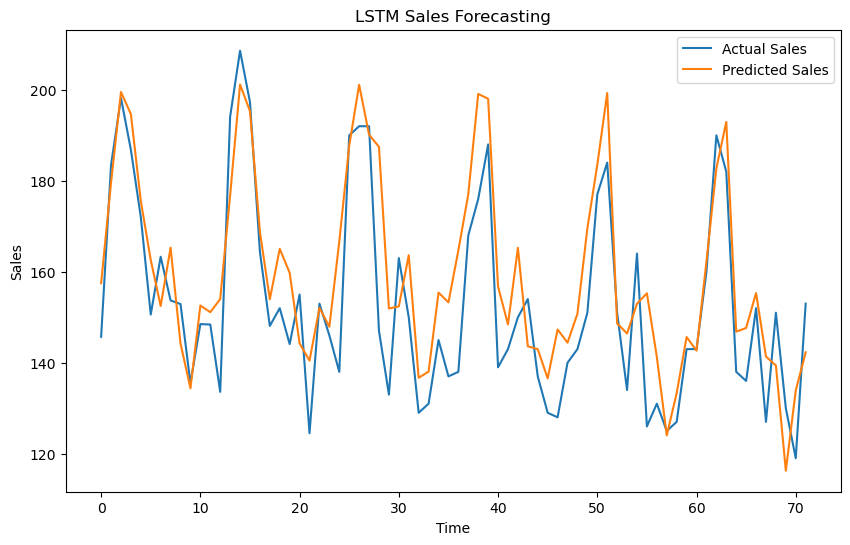

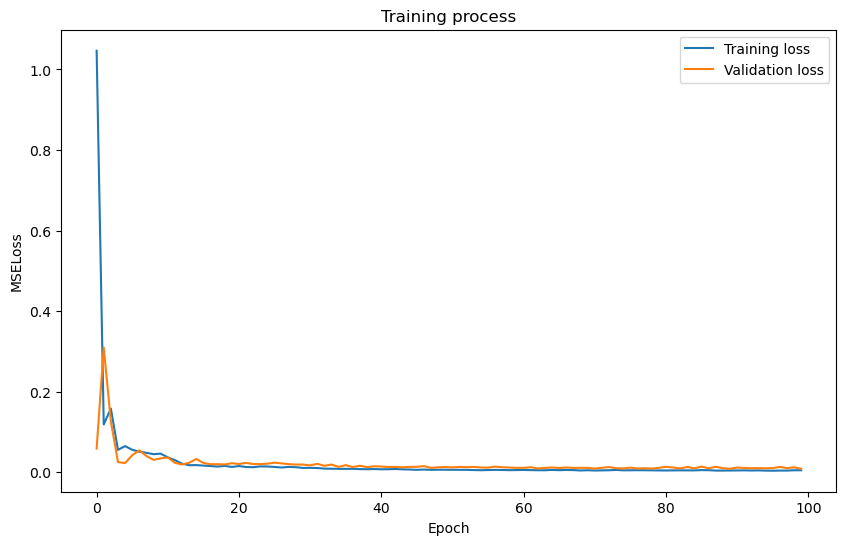

In [18]:

test_and_visualize(model,losses,test_loader,scaler)